In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

In [2]:
train_on_gpu=torch.cuda.is_available()
if train_on_gpu:
    print('CUDA OK')
else:
    print('CUDA NG')

CUDA OK


### Load Data

In [3]:
data_dir='./data/flower_photos/'
train_dir=os.path.join(data_dir, 'train/')
test_dir=os.path.join(data_dir, 'test')
print(train_dir, test_dir)
classes="daisy dandelion roses sunflowers tulips".split()
print(classes)

data_transform=transforms.Compose([
    transforms.RandomResizedCrop(size=(7*2**5, 7*2**5)),
    transforms.ToTensor()
])

train_data=datasets.ImageFolder(train_dir, data_transform)
test_data=datasets.ImageFolder(test_dir, data_transform)

print(type(train_data), len(train_data))
print(type(test_data), len(test_data))

sample, target = train_data[0]
classes=train_data.classes
print(sample.shape, target, classes[target])

./data/flower_photos/train/ ./data/flower_photos/test
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
<class 'torchvision.datasets.folder.ImageFolder'> 3130
<class 'torchvision.datasets.folder.ImageFolder'> 540
torch.Size([3, 224, 224]) 0 daisy


### DataLoaders and Data Visulization

<class 'torch.utils.data.dataloader.DataLoader'> 157
torch.Size([20, 3, 224, 224]) torch.Size([20])


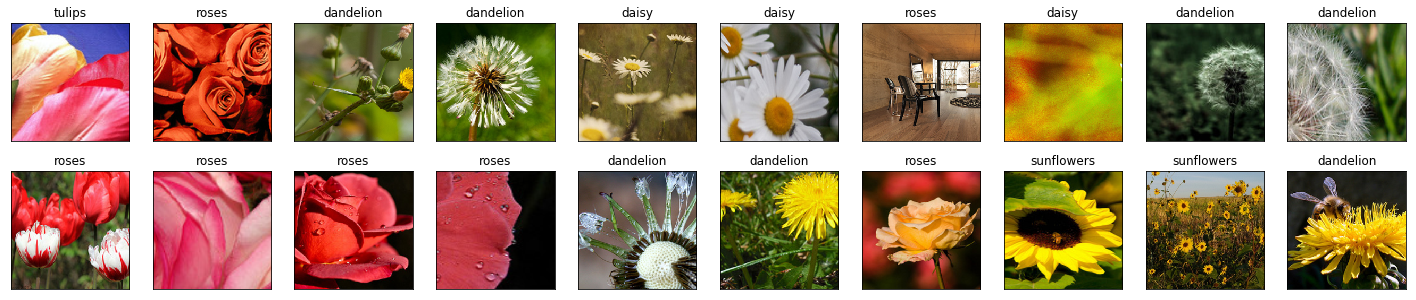

In [4]:
batch_size=20
num_workers=0

train_loader=DataLoader(train_data, batch_size=batch_size,
                        num_workers=num_workers, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size,
                        num_workers=num_workers, shuffle=True)

print(type(train_loader), len(train_loader))
dataiter=iter(train_loader)
images, labels = dataiter.next()

print(images.shape, labels.shape)

fig=plt.figure(figsize=(25,5))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
plt.show()

### Define Model

In [5]:
vgg16=models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [6]:
vgg16.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [7]:
for param in vgg16.features.parameters():
    param.requires_grad=False

### Final Classifer Layer

In [8]:
n_inputs=vgg16.classifier[-1].in_features
last_layer=nn.Linear(n_inputs, len(classes))
vgg16.classifier[-1] = last_layer

if train_on_gpu:
    vgg16.cuda()
    
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [9]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(vgg16.parameters(), lr=0.001)

In [ ]:
n_epochs=2

for epoch in range(1, n_epochs+1):
    train_loss=0.0
    for batch_i, (data, target) in enumerate(train_loader):
        if train_on_gpu:
            data, target=data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        output=vgg16(data)
        loss=criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        
        if batch_i % 20 == 19:
            print('Epoch %d, Batch %d, loss: %.16f' % 
                 (epoch, batch_i, train_loss / 20))
            
            train_loss=0.0